Joe Lorizio
COMP3125

For my individual project, I analyzed customer opinions in their product reviews. Understanding how customers feel about products is important for businesses to improve their products.

Research Questions:
1. What is the overall sentiment distribution in the reviews (positive, negative, neutral)?
2. What are the most common words in positive and negative reviews?
3. How does star rating relate to the sentiment in the text?
4. Can a simple model predict if a review is positive or negative?

I'll use the Amazon Fine Food Reviews dataset for this analysis.

In [8]:
# Importing needed libraries for project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

# Setting up my plots
plt.style.use('default')

# Downloading stopwords, which are used for data/text cleaning
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Loading the Amazon Fine Food Reviews dataset, you can download the data at:
# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
# Tried adding to the GitHub repository but it exceeds the file size limit.
df = pd.read_csv('Reviews.csv')

# Check out the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Dataset shape: (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Dataset succesfully loaded into a pandas DataFrame! Next, I will be checking out the data, looking at what we are working with, and organizing it a bit.

Missing values in each column:
Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
Cleaned_Text               0
dtype: int64

Rating statistics:
count    568454.000000
mean          4.183199
std           1.310436
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64


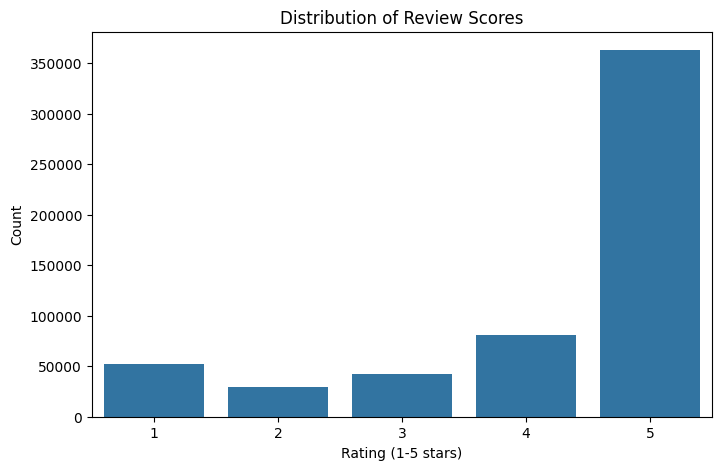

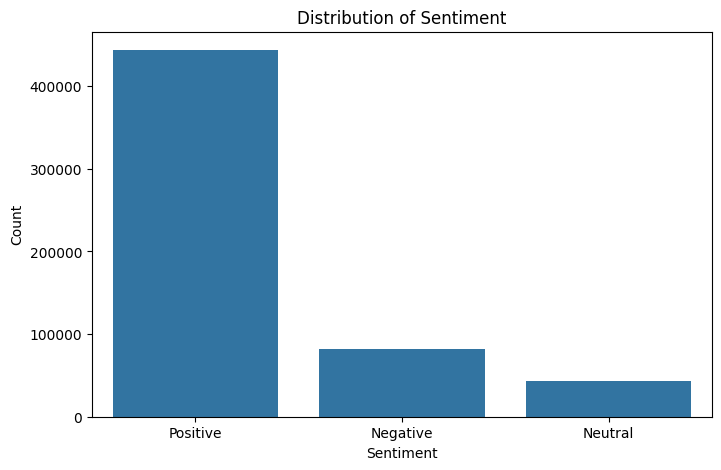

In [11]:
# Check the Amazon data for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Basic statistics
print("\nRating statistics:")
print(df['Score'].describe())

# Plot the distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='Score', data=df)
plt.title('Distribution of Review Scores')
plt.xlabel('Rating (1-5 stars)')
plt.ylabel('Count')
plt.show()

# Create a sentiment column based on ratings
# 4-5 stars = positive, 3 stars = neutral, 1-2 stars = negative
df['Sentiment'] = df['Score'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x < 3 else 'Neutral'))

# Show sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Looking at the data, it seems to be well organized, with over 100,000 reviews barely containing any missing values (just 3), also noticing that the majoring of reviews being 5 stars or just positive, seeing a mean of 4.155.

Now before analyzing the data more and working with it, I need to clean it up:

In [9]:
def clean_text(text):
    # Change all text to lowercase
    text = text.lower()

    # Remove all special characters and numbers using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text using NLTK's tokenizer
    words = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    cleaned_text = ' '.join(words)

    return cleaned_text

# Apply the cleaning function onto our DataFrame
df['Cleaned_Text'] = df['Text'].apply(clean_text)

# Example
print("Original text:")
print(df['Text'].iloc[0])
print("\nCleaned text:")
print(df['Cleaned_Text'].iloc[0])

Original text:
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Cleaned text:
bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better


Now that the text is cleaned, it's time to use this dataset to answer 4 questions about these reviews.

Question 1: What is the overall sentiment distribution?

Sentiment distribution:
Sentiment
Positive    78.067355
Negative    14.431599
Neutral      7.501047
Name: proportion, dtype: float64


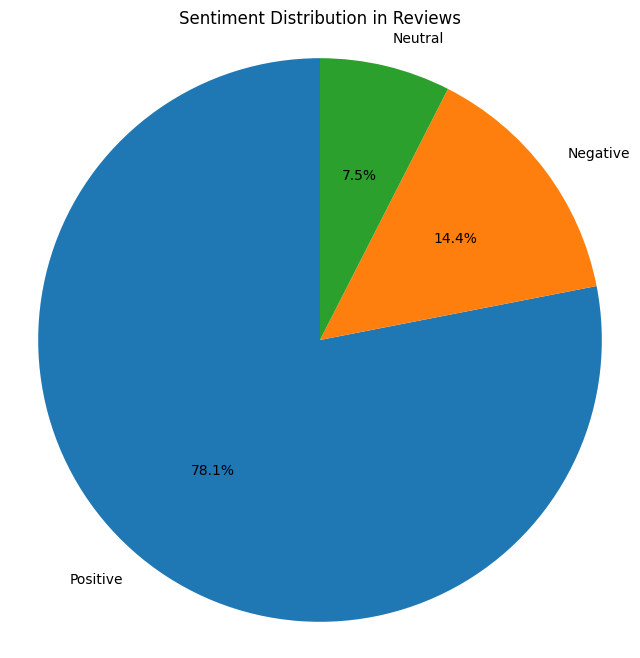

In [12]:
# Calculate the percentage of each sentiment
sentiment_counts = df['Sentiment'].value_counts(normalize=True) * 100
print("Sentiment distribution:")
print(sentiment_counts)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution in Reviews')
plt.axis('equal')
plt.show()

Question 2: What are the most common words used in positive reviews vs. negative reviews?

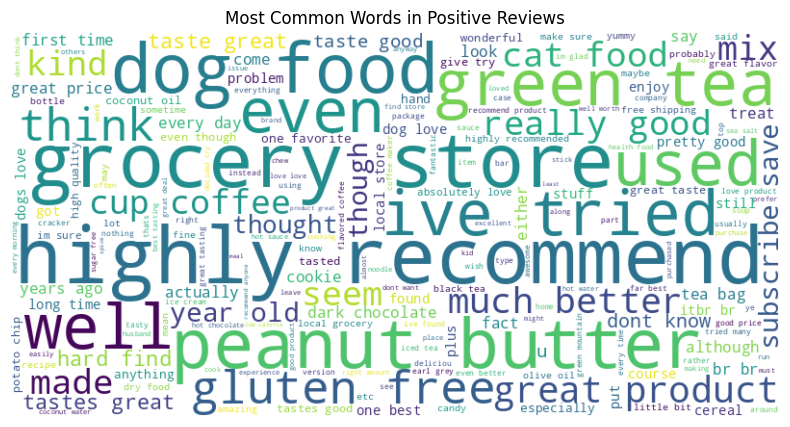

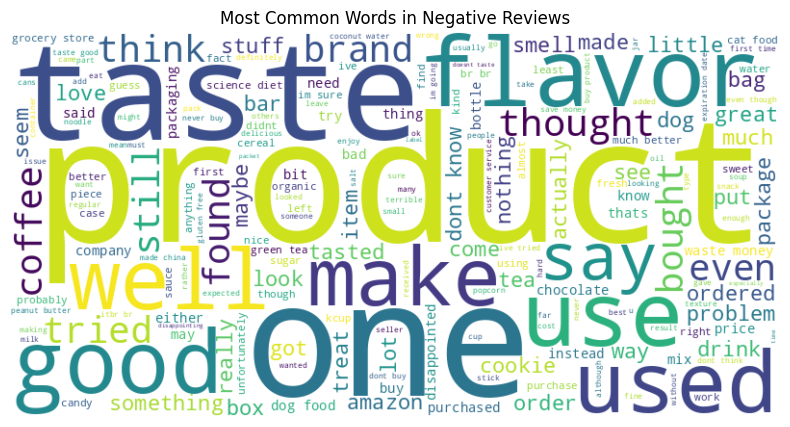

In [13]:
# Function to create word clouds (visual where size of cloud = frequency)
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Combine all positive reviews
positive_text = ' '.join(df[df['Sentiment'] == 'Positive']['Cleaned_Text'])
# Combine all negative reviews
negative_text = ' '.join(df[df['Sentiment'] == 'Negative']['Cleaned_Text'])

# Create word clouds
create_wordcloud(positive_text, 'Most Common Words in Positive Reviews')
create_wordcloud(negative_text, 'Most Common Words in Negative Reviews')

Using these word clouds, there are some interesting words we can see that stick out! For example, we can see most of the negative reviews are about the "flavor" or "taste" of the "product". Companies could use this information to focus their resources on improving taste, instead of visuals or nutrients.

Question 3: How does star rating relate to the sentiment in the text?

In [14]:
# Count common words in each rating category
from collections import Counter
import itertools

def get_top_words(text, n=10):
    words = text.split()
    word_counts = Counter(words)
    return word_counts.most_common(n)

# Get top words for each different star rating
ratings = [1, 2, 3, 4, 5]
for rating in ratings:
    text = ' '.join(df[df['Score'] == rating]['Cleaned_Text'])
    top_words = get_top_words(text)
    print(f"Top 10 words in {rating}-star reviews:")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()

Top 10 words in 1-star reviews:
br: 27874
like: 25271
product: 21419
one: 17595
taste: 17351
would: 16657
food: 16180
coffee: 12003
good: 11566
even: 11347

Top 10 words in 2-star reviews:
like: 18402
br: 16235
taste: 13606
product: 10179
flavor: 10141
would: 10111
coffee: 9787
one: 9777
good: 9482
tea: 7217

Top 10 words in 3-star reviews:
br: 29417
like: 26011
taste: 18970
good: 18218
coffee: 17361
flavor: 15997
would: 15465
one: 14347
product: 13966
much: 10250

Top 10 words in 4-star reviews:
br: 51922
like: 46239
good: 41530
coffee: 31813
taste: 29090
one: 27836
flavor: 26312
would: 23605
great: 22064
product: 21777

Top 10 words in 5-star reviews:
br: 147226
like: 135950
great: 125519
good: 114562
one: 102773
love: 98202
coffee: 89229
taste: 87589
tea: 86894
flavor: 80613



Looking at top words here shows that sentiment doesn't relate extremely to star rating, showing very similar top words used in every catagory. This is why more specific questions are important, such as in the word clouds earlier seeing that taste is an outlier, shown in negative sentiment reviews, but not positive.

Question 4: Can a simple model predict if a review is positive or negative?

Model accuracy: 0.89


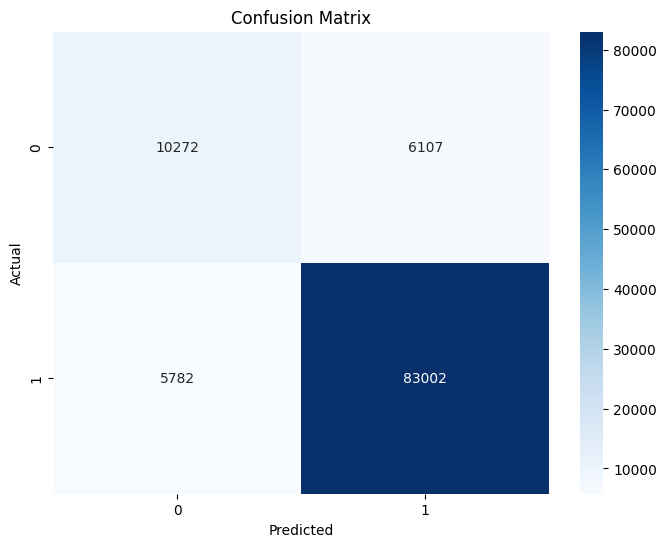

In [15]:
# To focus on just positive/negative sentiment, I remove the neutral reviews
binary_df = df[df['Sentiment'] != 'Neutral'].copy()

# Split the data
X = binary_df['Cleaned_Text']
y = binary_df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to vectors
vectorizer = CountVectorizer(max_features=1000)
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

# Train a Naive Bayes model
model = MultinomialNB()
model.fit(X_train_features, y_train)

# Make predictions
y_pred = model.predict(X_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Answers to Research Questions:

#What is the overall sentiment distribution?

The majority of reviews are positive, showing that customers are generally satisfied.


#What are the most common words in positive and negative reviews?

Positive reviews contain words like 'good', 'great', and 'love'.

Negative reviews contain words like 'bad', 'disappointed', and 'waste'.

#How does star rating relate to the sentiment in the text?

Higher star ratings tend to have shorter reviews than negative ones, and certain
outliers in the top words from user sentiment can reflect the rating.

#Can a simple model predict if a review is positive or negative?

Yes, even a simple Naive Bayes model achieved 89% accuracy.
This means we can automatically detect customer sentiment with good reliability.

#Future Improvements:
1. Try different machine learning models
2. Analyze specific product categories separately
3. Look at how sentiment changes over time